In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def accuracy(ouputs, lables):
    __, preds = torch.max(ouputs, dim=1)
    return torch.tensor(torch.sum(preds == lables).item() / len(preds))

class ImgClassificactionBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def val_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def val_epoc_end(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoc_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoc_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoc_loss.item(), 'val_acc': epoc_acc.item()}
    def epoc_end(self, epoc, result): 
        print("Epoch"+str(epoc)+", train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(result['train_loss'], result['val_loss'], result['val_acc']))

def conv_bloc(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels,out_channels, kernel_size=3,stride=1 ,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU6(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImgClassificactionBase):
    def __init__(self, inchannels, num_classes):
        super().__init__()
        self.conv1 = conv_bloc(inchannels, 64) # 64,32,32
        self.conv2 = conv_bloc(64, 128, pool=True) # 128,16,16
        self.res1 = nn.Sequential(conv_bloc(128,128),
                                  conv_bloc(128,128))#128,16,16
        self.conv3 = conv_bloc(128,256,pool=True)#256,8,8
        self.conv4 = conv_bloc(256,512,pool=True)#512,4,4
        self.res2 = nn.Sequential(conv_bloc(512,512),
                                  conv_bloc(512,512))#512,4,4
        self.classifier = nn.Sequential(nn.MaxPool2d(4), #512,1,1
                                        nn.Flatten(), #512
                                        nn.Dropout(0.2), #drops 20% of inputs
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [3]:
classes =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = get_default_device()
IM = ImageFolder
test_dir = './self_test'
model_path = './models/Saved-number-aug-CNN-model.pt'

In [4]:
device

device(type='cuda')

In [5]:
torch.cuda.empty_cache()
#model = torch.load(model_path,torch.device('cpu'))
model = torch.load(model_path)

Label: cat , Prediction:  cat


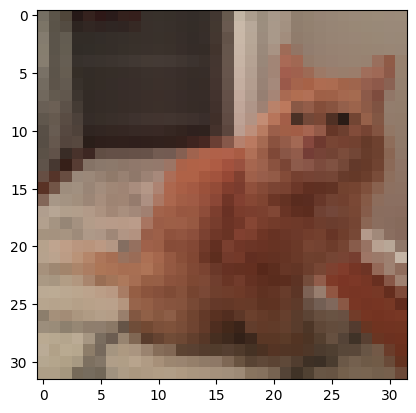

In [8]:
ds_show = IM(test_dir, transform= tt.ToTensor())
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # ((mean),(std_div)) in R,G,B
val_tf = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
ds = IM(test_dir, transform= val_tf)
###################
###################
index = 1
###################
###################
from pred import predict_image as PI
imgs, __ = ds_show[index]
img , label = ds[index]
plt.imshow(imgs.permute((1,2,0)))
print('Label:',ds.classes[label],', Prediction: ',classes[PI(img, model, device)])